In [79]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.special import softmax
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys
import torch
#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import idistill.model
import idistill.data
from idistill.ftd import FTDistillRegressorCV
from idistill.whitebox_figs import FIGSRegressor
from idistill.subset_predictors import L0L2RegressorCV

sys.path.append('/home/mattyshen/iCBM')

from CUB.template_model import End2EndModel, Inception3, MLP

class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
            
def fit_model(model, X_train, y_train, feature_names, r):
    # fit the model
    fit_parameters = inspect.signature(model.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        model.fit(X_train, y_train, feature_names=feature_names)
    else:
        model.fit(X_train, y_train)

    return r, model

def evaluate_model(model, X_train, X_val, y_train, y_val, comp, seed, r):
    """Evaluate model performance on each split"""
    metrics = {
            "accuracy": accuracy_score,
        }
    for split_name, (X_, y_) in zip(
        ["trainval", "test"], [(X_train, y_train), (X_val, y_val)]
    ):
        y_pred_ = model.predict(X_)
        if len(y_pred_.shape) > 1 and y_pred_.shape[1] > 1:
            #handle regressors
            y_pred_ = np.argmax(y_pred_, axis=1)
        for i, (metric_name, metric_fn) in enumerate(metrics.items()):
            print(metric_fn(y_, y_pred_))
            r[f"{comp}_seed{seed}_{metric_name}_{split_name}"] = metric_fn(y_, y_pred_)

    return r

def load_csvs(path):

    X_train = pd.read_csv(f'{path}/X_trainval.csv', index_col=0)
    X_train_hat = pd.read_csv(f'{path}/X_trainval_hat.csv', index_col=0)
    X_test = pd.read_csv(f'{path}/X_test.csv', index_col=0)
    X_test_hat = pd.read_csv(f'{path}/X_test_hat.csv', index_col=0)
    y_train = pd.read_csv(f'{path}/y_trainval.csv', index_col=0)
    y_train_hat = pd.read_csv(f'{path}/y_trainval_hat.csv', index_col=0)
    y_test = pd.read_csv(f'{path}/y_test.csv', index_col=0)
    y_test_hat = pd.read_csv(f'{path}/y_test_hat.csv', index_col=0)

    return X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat

def find_optimal_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def find_thresh(linkage_matrix, min_clusters=10, max_clusters=15, step=0.1, count = 0):
    if count > 3:
        print(max_clusters)
        return find_thresh(linkage_matrix, min_clusters=min_clusters, max_clusters=(max_clusters-5*4)-1, step=step, count = 0)
    threshold = 4.9
    while threshold < 10:
        clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
        num_clusters = len(set(clusters))
        if min_clusters <= num_clusters <= max_clusters:
            return threshold, num_clusters
        threshold += step
    print('find_thresh recursive call beginning')
    return find_thresh(linkage_matrix, min_clusters=min_clusters, max_clusters=max_clusters+5, step=0.1, count = count+1)
    #return None, 0

def cluster_concepts(X, num_clusters):
    distance_matrix = 1 - X_train_hat.corr().abs()
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    
    threshold, _ = find_thresh(linkage_matrix, min_clusters=num_clusters-5, max_clusters=num_clusters, step=0.1)
        
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    feature_groups = {}
    for i, cluster_id in enumerate(clusters):
        feature_groups.setdefault(cluster_id, []).append(distance_matrix.columns[i])
    
    return feature_groups

def process_X(X_train, X_train_hat, X_test, X_test_hat, prepro, num_clusters, thresh=0):
    if prepro == "probs":
        return X_train_hat, X_test_hat, None
    elif prepro == 'cluster':
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'global':
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        opt_thresh = find_optimal_threshold(X_train.values.reshape(-1, ), X_train_hat.values.reshape(-1, ))
        
        return (X_train_hat > opt_thresh).astype(int), (X_test_hat > opt_thresh).astype(int), f_gs
    elif prepro == 'gpt1':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c'+str(i) for i in range(53, 55)]+['c'+str(i) for i in range(100, 104)],
                2:['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c78'],
                3:['c'+str(i) for i in range(11, 17)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(65, 71)]+['c'+str(i) for i in range(104, 110)],
                4:['c'+str(i) for i in range(17, 24)]+['c'+str(i) for i in range(40, 51)]+['c'+str(i) for i in range(24, 26)]+['c'+str(i) for i in range(71, 78)]+['c'+str(i) for i in range(60, 65)],
                5:['c'+str(i) for i in range(32, 38)]+['c'+str(i) for i in range(88, 91)],
                6:['c38', 'c39', 'c51','c52']+['c'+str(i) for i in range(55, 60)],
                7:['c'+str(i) for i in range(97, 100)],
                8:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(79, 85)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'gpt2':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c'+str(i) for i in range(53, 55)]+['c32']+['c'+str(i) for i in range(78, 85)],
                2:['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c'+str(i) for i in range(33, 38)]+['c'+str(i) for i in range(88, 91)],
                3:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(11, 17)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(17, 24)]+['c'+str(i) for i in range(60, 65)],
                4:['c'+str(i) for i in range(40, 51)]+['c24', 'c25']+['c'+str(i) for i in range(104, 110)]+['c'+str(i) for i in range(55, 60)]+['c'+str(i) for i in range(65, 78)],
                5:['c38', 'c39', 'c51','c52'],
                6:['c'+str(i) for i in range(100, 104)]+['c'+str(i) for i in range(97, 100)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'gpt3':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c53', 'c54']+['c'+str(i) for i in range(100, 104)],
                2:['c78', 'c32']+['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c'+str(i) for i in range(88, 91)]+['c'+str(i) for i in range(33, 38)],
                3:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(11, 24)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(55, 78)]+['c'+str(i) for i in range(104, 110)],
                4:['c'+str(i) for i in range(40, 51)]+['c24', 'c25', 'c38', 'c39', 'c51', 'c52'],
                5:['c'+str(i) for i in range(79, 85)],
                6:['c'+str(i) for i in range(97, 100)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    
    elif prepro == 'gpt4':
        f_gs = {1:[1,3,5,7,8,11,12,15,16,19,20,21,22,24,26,27,40,41,42,43,46,49,50,53,55,56,60,62,64,65,66,69,70,71,72,77,78,79,80,83,84,85,87,88,90,91,92,93,94,95,102,106,107,108,110],
                2:[4,6,10,13,14,17,18,23,25,29,54,73,76,86,89,97,98,104,105,111],
                3:[2,9,28,30,32,33,34,35,36,37,38,39,47,48,51,52,81,96,99],
                4:[31,44,45,57,58,59,61,63,67,68,74,75,82,100,101,103,109,112]
        }
        
        for k in f_gs.keys():
            f_gs[k] = ['c'+str(i) for i in f_gs[k]]
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
        
    elif prepro == 'binary' and thresh > 0:
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        return (X_train_hat > thresh).astype(int), (X_test_hat > thresh).astype(int), f_gs
    else:
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        optimal_thresholds = []
        for class_idx in range(X_train_hat.shape[1]):
            y_true_class = X_train.iloc[:, class_idx]
            y_probs_class = X_train_hat.iloc[:, class_idx]
            optimal_thresholds.append(find_optimal_threshold(y_true_class, y_probs_class))
        optimal_thresholds = np.array(optimal_thresholds)
        
        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    
def process_y(y_train, y_train_hat, y_test, y_test_hat, prepro):
    if prepro == "probs":
        return softmax(y_train_hat, axis=1), softmax(y_test_hat, axis=1)
    elif prepro == "classes":
        return pd.DataFrame(y_train_hat.idxmax(axis=1).astype(int)), pd.DataFrame(y_test_hat.idxmax(axis=1).astype(int))
    else:
        return y_train_hat, y_test_hat

In [85]:
args_dict = {}
args_dict['task_type'] = 'regression'
args_dict['model_name'] = 'FIGSRegressor'
args_dict['X_type'] = 'binary'
args_dict['thresh'] = 0.45
args_dict['Y_type'] = 'probs'
args_dict['max_rules'] = 90
args_dict['max_trees'] = 20
args_dict['max_depth'] = 3
args_dict['device'] = 'cuda:0'
args_dict['num_clusters'] = 5
args_dict['num_bootstraps'] = 2

args = ARGS(args_dict)
r = {}

In [86]:
X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat = load_csvs(f'/home/mattyshen/DistillationEdit/data/cub_tabular/seed0_Joint0.01SigmoidModel__Seed1')

In [87]:
X_train_model, X_test_model, clusters = process_X(X_train, X_train_hat, X_test, X_test_hat, args.X_type, args.num_clusters, args.thresh)
y_train_model, y_test_model = process_y(y_train, y_train_hat, y_test, y_test_hat, args.Y_type)

In [88]:
model = FIGSRegressor(max_rules = args.max_rules, max_trees = args.max_trees, max_depth = args.max_depth)
r, model = fit_model(model, X_train_model, y_train_model, None, r)

In [89]:
def extract_interactions(model):
    """
    Extracts all feature interactions from the FIGS model by parsing through each additive tree.

    Parameters:
        model: A FIGS model containing an attribute `trees_`.
               Each tree is comprised of hierarchically linked `Node` objects.

    Returns:
        interactions: A list of sets, where each set contains the features involved in an interaction.
    """
    interactions = []

    def traverse_tree(node, current_features, current_depth):
        """
        Recursively traverse a tree to collect feature interactions.

        Parameters:
            node: The current `Node` object in the tree.
            current_features: A set of features encountered so far in the current path.
        """
        if node.left is None and node.right is None:
            cur_interactions.append((current_features, node.value))
            return

        # Add the current feature to the set of features for this path

        # If the node has children, traverse them
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)

    # Loop through each tree in the model
    # traverse_tree(model.trees_[0], set(), current_depth=0)
    # return interactions
    for tree in model.trees_:
        # Start traversal for each tree
        cur_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(cur_interactions)
    return interactions

In [90]:
cur_interactions = extract_interactions(model)

In [91]:
X_train_figs = pd.DataFrame()

In [92]:
X_train_figs = []
class_corr = []
for i, tree in enumerate(cur_interactions):
    for j, (t_i, v) in enumerate(tree):
        cur_inter = pd.Series(np.ones(X_train_model.shape[0]))
        for c in t_i:
            if c[0] == '!':
                cur_inter *= (X_train_model[c[1:]] > 0.5)
            else:
                cur_inter *= (X_train_model[c] <= 0.5)
                
        X_train_figs.append(pd.Series(cur_inter, name = ','.join(cur_interactions[i][j][0])))
        class_corr.append(pd.Series(v, name = ','.join(cur_interactions[i][j][0])))
X_train_figs = pd.concat(X_train_figs, axis = 1)
class_corr = pd.concat(class_corr, axis = 1).T

In [93]:
X_test_figs = []
for i, tree in enumerate(cur_interactions):
    for j, (t_i, v) in enumerate(tree):
        cur_inter = pd.Series(np.ones(X_test_model.shape[0]))
        for c in t_i:
            if c[0] == '!':
                cur_inter *= (X_test_model[c[1:]] > 0.5)
            else:
                cur_inter *= (X_test_model[c] <= 0.5)
        X_test_figs.append(pd.Series(cur_inter, name = ','.join(cur_interactions[i][j][0])))        
X_test_figs = pd.concat(X_test_figs, axis = 1)

In [94]:
X_train_figs.sum(axis = 1).value_counts()

20.0    5984
dtype: int64

In [95]:
partial_preds=model.predict(X_train_model)

In [96]:
np.mean(abs(np.sum(partial_preds, axis =2) - (X_train_figs @class_corr).values) < 0.001)

1.0

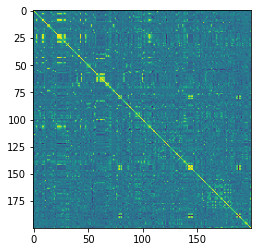

In [97]:
import matplotlib.pyplot as plt
plt.imshow(class_corr.corr())

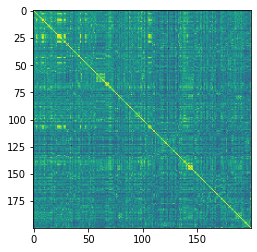

In [98]:
plt.imshow(class_corr.apply(lambda row: class_corr.shape[1] - row.rank().astype(int) + 1, axis=0).corr())

In [99]:
#postprocess

In [100]:
preds = model.predict(X_train_model)

In [101]:
accuracy_score(np.argmax(np.sum(model.predict(X_test_model), axis = 2), axis = 1), y_test)

0.7197100448740076

In [102]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import RidgeCV

In [103]:
figs_new = MultiOutputRegressor(RidgeCV(alphas = np.arange(0.01, 1.5, 0.1)))

In [104]:
figs_new.fit(X_train_figs, y_train_model)

MultiOutputRegressor(estimator=RidgeCV(alphas=array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41])))

In [105]:
accuracy_score(np.argmax(figs_new.predict(X_test_figs), axis = 1), y_test)

0.7176389368312047

In [106]:
#r2_score(ridge.predict(X_train_figs.values), y_train_model.values[:, 1])

In [109]:
y_train_model.shape

(5984, 200)

In [110]:
r2_score(np.sum(model.predict(X_train_model), axis = 2)[:,1],y_train_model[:, 1])

0.2062649187258465

In [25]:
#r2_score(figs_new.predict(X_test_figs.values), y_test_model.values[:, 1])

In [111]:
r2_score(np.sum(model.predict(X_test_model), axis = 2)[:,1], y_test_model[:, 1])

0.2630859214233542

(array([ 1.,  3., 13., 22., 24., 13.,  2.,  3.,  0.,  1.]),
 array([-0.05075938, -0.03843353, -0.02610769, -0.01378185, -0.001456  ,
         0.01086984,  0.02319568,  0.03552153,  0.04784737,  0.06017322,
         0.07249906]),
 <BarContainer object of 10 artists>)

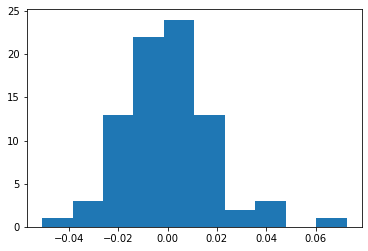

In [112]:
plt.hist(figs_new.estimators_[2].coef_)

In [113]:
figs_new.estimators_[0].coef_.shape

(82,)

(array([18., 49., 11.,  2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.01404382, -0.00545793,  0.00312796,  0.01171386,  0.02029975,
         0.02888564,  0.03747153,  0.04605743,  0.05464332,  0.06322921,
         0.0718151 ]),
 <BarContainer object of 10 artists>)

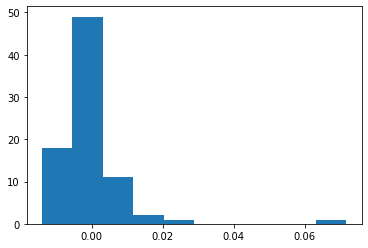

In [114]:
plt.hist(class_corr.iloc[:, 2])

In [115]:
np.mean(figs_new.estimators_[10].coef_), np.mean(class_corr.iloc[:, 10])

(6.067301133050589e-17, -0.0026690512139728724)

In [116]:
figs_sparse = MultiOutputRegressor(L0L2RegressorCV(max_support_size = 20))
figs_sparse.fit(X_train_figs, y_train_model)

MultiOutputRegressor(estimator=L0L2RegressorCV(max_support_size=20))

In [117]:
accuracy_score(np.argmax(figs_sparse.predict(X_test_figs), axis = 1), y_test)

0.6430790472903003

In [118]:
#r2_score(figs_sparse.predict(X_train_figs.values), y_train_model[:, 1])

In [119]:
r2_score(np.sum(model.predict(X_train_model), axis = 2)[:,1],y_train_model.values[:, 1])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [120]:
figs_sparse.estimators_[0].coef_

array([ 0.01307776,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00750684,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.02406719,  0.        ,  0.00848267,
        0.        ,  0.        ,  0.        ,  0.01352071,  0.        ,
        0.        ,  0.        ,  0.01229073,  0.        ,  0.        ,
        0.        ,  0.0087695 ,  0.        ,  0.        ,  0.        ,
        0.        , -0.01549311,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00958367,  0.        ,  0.        ,  0.        , -0.00694101,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00893696,  0.        ,  0.        ,  0.00438573,
        0.        ,  0.        ,  0.        ,  0.01613157,  0.        ,
       -0.00915845,  0.        ,  0.00725223,  0.        ,  0.        ,
        0.        ,  0.00636451,  0.        ,  0.        ,  0.  

In [121]:
def split_coefficients(coefs, sizes):
    result = []
    start = 0
    for size in sizes:
        end = start + size
        result.append(coefs[start:end])
        start = end
    return result

(array([ 2.,  7., 16., 35.,  0., 39., 54., 32., 12.,  3.]),
 array([10. , 10.8, 11.6, 12.4, 13.2, 14. , 14.8, 15.6, 16.4, 17.2, 18. ]),
 <BarContainer object of 10 artists>)

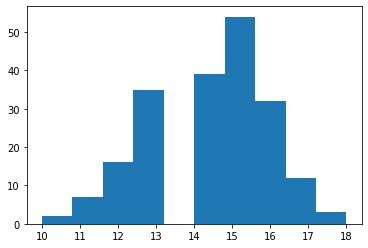

In [122]:

surviving_trees = [sum([np.any(i != 0) for i in split_coefficients(figs_sparse.estimators_[j].coef_, [len(i) for i in cur_interactions])]) for j in range(200)]


plt.hist(surviving_trees)

In [123]:
preds[:, i, ].shape, X_train_figs.shape, y_train_model.shape

((5984, 20), (5984, 82), (5984, 200))

In [124]:
preds_test = model.predict(X_test_model)

In [126]:
preds[:, i, ].shape

(5984, 20)

In [128]:
models = []
for i in range(200):
    m = L0L2RegressorCV(max_support_size = 10)
    m.fit(pd.DataFrame(preds[:, i, ]), y_train_model[:, i])
    models.append(m)

In [49]:
preds[:, 0, :].shape

(5984, 24)

In [129]:
sparse_preds = np.array([m.predict(preds_test[:, i, :]).reshape(-1, ) for i, m in enumerate(models)]).T

In [130]:
(models[0].coef_ * preds[:, 0, :])

array([[ 3.74548933e-03,  0.00000000e+00,  0.00000000e+00, ...,
         9.47774482e-04,  1.36340304e-03, -0.00000000e+00],
       [ 9.55775403e-05,  0.00000000e+00,  0.00000000e+00, ...,
         9.47774482e-04,  1.36340304e-03, -0.00000000e+00],
       [ 4.02343907e-05,  0.00000000e+00,  0.00000000e+00, ...,
         9.47774482e-04, -1.24176795e-03,  0.00000000e+00],
       ...,
       [ 3.74548933e-03,  0.00000000e+00,  0.00000000e+00, ...,
         9.47774482e-04,  1.36340304e-03, -0.00000000e+00],
       [ 3.74548933e-03,  0.00000000e+00,  0.00000000e+00, ...,
        -2.52298845e-03, -1.24176795e-03, -0.00000000e+00],
       [ 3.74548933e-03,  0.00000000e+00,  0.00000000e+00, ...,
         9.47774482e-04, -1.24176795e-03, -0.00000000e+00]])

In [131]:
preds_test[:, i, :].shape

(5794, 20)

In [132]:
accuracy_score(np.argmax(sparse_preds, axis = 1), y_test)

0.627890921643079

In [133]:
split_coefficients(figs_sparse.estimators_[0].coef_, [len(i) for i in cur_interactions])

[array([0.01307776, 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([0.00750684, 0.        , 0.        , 0.        ]),
 array([ 0.        ,  0.        , -0.02406719,  0.        ]),
 array([0.00848267, 0.        , 0.        , 0.        ]),
 array([0.01352071, 0.        , 0.        , 0.        ]),
 array([0.01229073, 0.        , 0.        , 0.        ]),
 array([0.0087695, 0.       , 0.       , 0.       ]),
 array([ 0.        , -0.01549311,  0.        ,  0.        ]),
 array([0., 0., 0., 0.]),
 array([0.        , 0.        , 0.00958367, 0.        ]),
 array([ 0.        ,  0.        , -0.00694101,  0.        ]),
 array([0., 0., 0., 0.]),
 array([0.        , 0.00893696, 0.        , 0.        ]),
 array([0.00438573, 0.        , 0.        , 0.        ]),
 array([ 0.01613157,  0.        , -0.00915845,  0.        ]),
 array([0.00725223, 0.        , 0.        , 0.        ]),
 array([0.00636451, 0.        , 0.        , 0.        ]),
 array([0.00956643, 0.        , 0.

In [134]:
t.shape, models[0].coef_.shape

((5984, 24), (20,))

In [136]:
ridge_models = []
for m in models:
    r = RidgeCV(alphas = np.arange(0.01, 1.5, 0.1))
    r.fit(pd.DataFrame(preds[:, i, ]).loc[:, m.coef_ != 0], y_train_model[:, i])
    ridge_models.append(r)

In [137]:
ridge_preds = np.array([r.predict(pd.DataFrame(preds_test[:, i, :]).loc[:, m.coef_ != 0]).reshape(-1, ) for i, (r, m) in enumerate(zip(ridge_models, models))]).T

In [138]:
accuracy_score(np.argmax(ridge_preds, axis = 1), y_test)

0.5824991370383155

In [144]:
y_train_model[:, 0]

array([3.21361862e-04, 1.73337965e-04, 5.58037581e-05, ...,
       7.52642487e-01, 6.68272809e-03, 8.18682295e-04])